In [40]:
import os
import sys
import json
import random
import pickle
from datetime import datetime
from glob import glob
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import h5py
import obspy
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from scipy import stats, signal
from tqdm import tqdm
from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms

# Add custom module path
module_path = os.path.abspath(os.path.join('scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)


#from helper_functions import apply_cosine_taper, butterworth_filter, resample_array
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from obspy.clients.fdsn import Client
client = Client('IRIS')


from helper_functions import extract_spectrograms

## Loading the trained models

In [8]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cpu"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_3036286/2040110301.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', 

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## Downloading and Preparing the input data

In [11]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:56.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:51.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:07:29.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:29:40.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:11:46.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:11:49.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:48:28.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [115]:
event = exotic.iloc[10]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3175703
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SEP
station_location_code                              --
station_latitude_deg                             46.2
station_longitude_deg                        -122.191
station_elevation_m                            2114.0
trace_name                       bucket1$44,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-11-07T07:07:42.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                       10.142|6.792|8.116
Name: 399, dtype: object


3 Trace(s) in Stream:
CC.SEP..BHE | 2021-11-07T07:07:32.000000Z - 2021-11-07T07:09:12.010000Z | 100.0 Hz, 10002 samples
CC.SEP..BHN | 2021-11-07T07:07:32.000000Z - 2021-11-07T07:09:12.010000Z | 100.0 Hz, 10002 samples
CC.SEP..BHZ | 2021-11-07T07:07:32.000000Z - 2021-11-07T07:09:12.010000Z | 100.0 Hz, 10002 samples


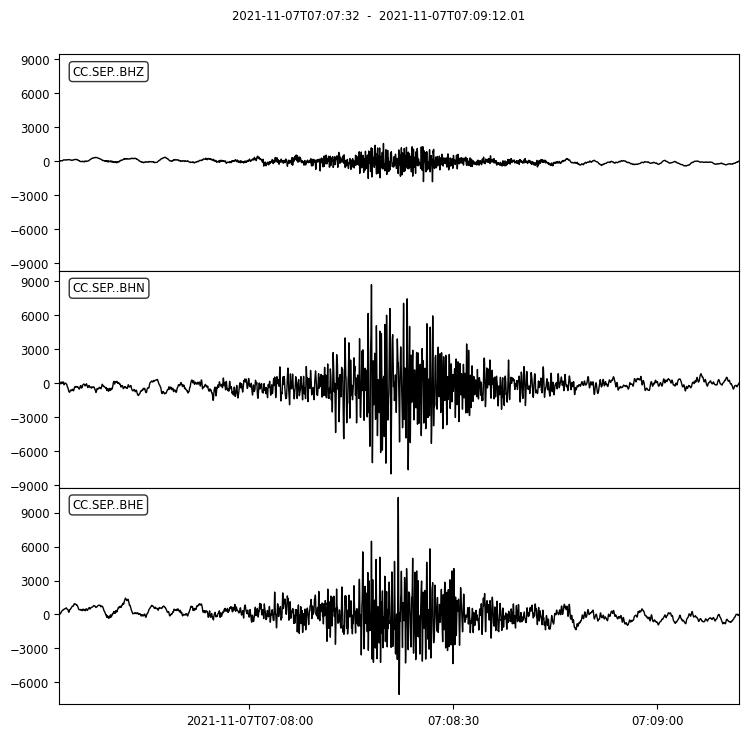

In [116]:
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)

s.detrend()
s.resample(100)
print(s)
s.plot();

In [117]:
# amount of tapering
taper_alpha = 0.1

# filter parameters
nyquist = 0.5 * 100  # Nyquist frequency (original sampling rate is 100 Hz)
lowcut = 1
highcut = 20
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients


# resampled frequency 
fs = 50

# event data
event_data = np.array(s)

# tapering before filtering
taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
tapered_data = np.array([np.multiply(taper, row) for row in event_data])
    
#Apply bandpass filtering
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])

# Resample the data to the target sampling rate
num_samples = int(filtered_data.shape[1] * fs / 100)  # Resample to target `fs`
resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

resampled_data = resampled_data[:,0:5000]

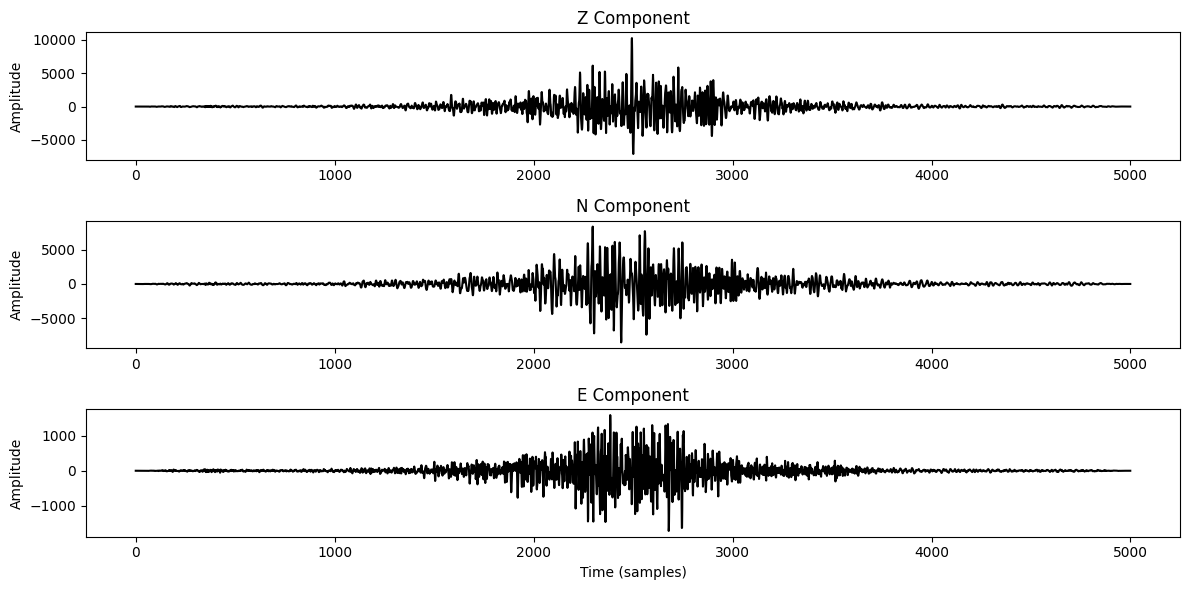

In [118]:
# Let's assume resampled_data has shape (3, N)
components = ['Z', 'N', 'E']
time = np.arange(resampled_data.shape[1])  # Or use actual time if available

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time, resampled_data[i], color='black')
    plt.title(f'{components[i]} Component')
    plt.ylabel('Amplitude')
    if i == 2:
        plt.xlabel('Time (samples)')

plt.tight_layout()
plt.show()


In [119]:
resampled_data = resampled_data.reshape(1,3, 5000)

In [120]:
spectrogram = extract_spectrograms(resampled_data)

100%|██████████| 1/1 [00:00<00:00, 1025.00it/s]

(1, 3, 129, 38)


In [121]:
nperseg=256
overlap=0.5
fs = 50
noverlap = int(nperseg * overlap)  # Calculate overlap
f, t, _ = signal.spectrogram(resampled_data[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

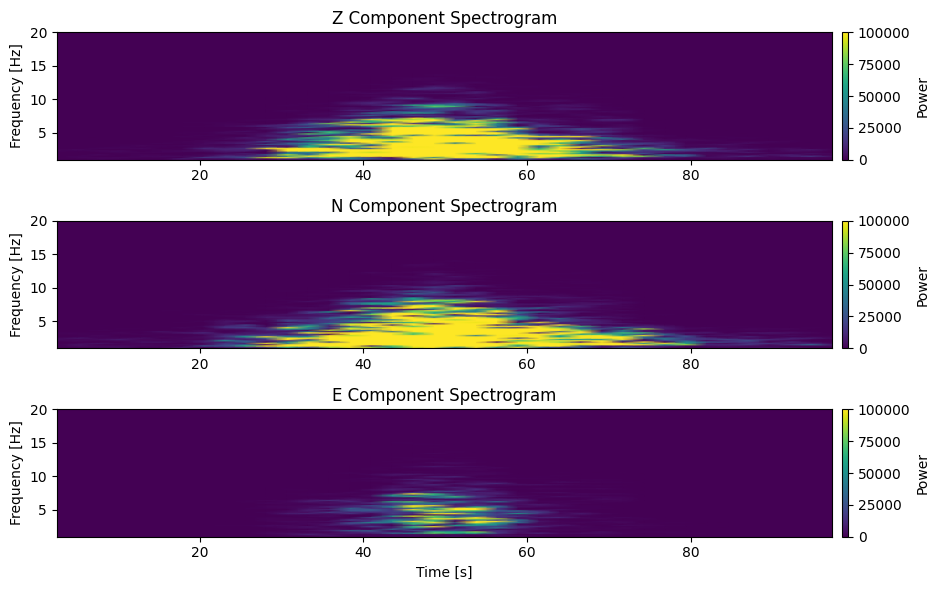

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Assume `spectrogram` has shape (1, 3, 129, 38)
# spectrogram = your_spectrogram_array
# f, t = frequencies and times from signal.spectrogram

components = ['Z', 'N', 'E']
spec = spectrogram[0]  # Remove batch dimension, now shape (3, 129, 38)

plt.figure(figsize=(10, 6))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(t, f, spec[i],  shading='gouraud', cmap='viridis', clim = [0,100000])
    plt.ylabel('Frequency [Hz]')
    plt.title(f'{components[i]} Component Spectrogram')
    plt.ylim(1,20)
    plt.colorbar(label='Power', pad=0.01)
    if i == 2:
        plt.xlabel('Time [s]')


plt.tight_layout()
plt.show()


In [123]:
model = model_seismiccnn_2d

In [124]:
inputs = torch.Tensor(spectrogram)

In [125]:
outputs = model(inputs)

In [126]:
outputs.argmax(1)

tensor([3])

In [127]:
outputs

tensor([[-174904.9219, -334081.5938,  426505.3125,  707636.2500]],
       grad_fn=<NativeBatchNormBackward0>)